# Reconstrucing astronomical spectra using Principle Component Analysis
Bayu Wilson

The purpose of this project is to review the process and power of Principle Component Analysis (PCA). This is not meant to be a rigorous calculation for quasar spectra reconstruction.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Loading XQ-100 quasar spectra

You'll have to download the data if you want to acutually run this. See the README.md for more details.

In [2]:
path_to_cat = "XQ100_data/XQ-100_catalogue.txt" #tells us names and redshift of each quasar.
catalog_table = pd.read_csv(path_to_cat,delim_whitespace=True,usecols=(3,6),
                                names = ("qso_name","redshifts"), comment='#')

df_tot = pd.DataFrame()
for i in range(len(catalog_table)):
    name = catalog_table["qso_name"].iloc[i]
    redshift = catalog_table["redshifts"].iloc[i]
    released_path = "XQ100_data/released/{0}_uvb-vis.txt".format(name)
    continuum_path = "XQ100_data/continuum/{0}_cont.txt".format(name)
    df_i = pd.read_csv(released_path, delim_whitespace=True, skiprows = 1,usecols=(0,1,2,3,4),
                                        names = ("wav", "flx", "ferr", "res","dloglam"))
    cont_table = pd.read_csv(continuum_path, delim_whitespace=True, skiprows = 1,usecols=(0,1),
            names = ("wav",'flx'))
    df_i["qso_idx"] = i
    df_i["redshift"] = redshift
    df_i["cont"] = cont_table["flx"]
    df_tot = pd.concat([df_tot,df_i])
df_tot["wav_rest"] = df_tot["wav"]/(1+df_tot["redshift"]) #shifting to rest frame

## Exploratory Data Analysis

### A typical quasar spectrum

Text(0.34, 0.47, 'hand-picked continuum')

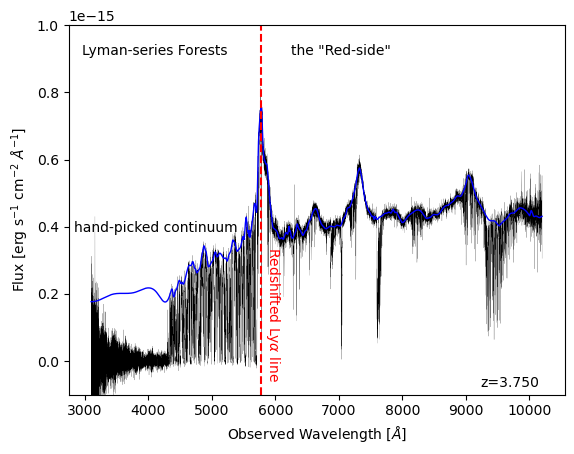

In [10]:
np.random.seed(1)
random_qso_idx = np.random.randint(0,100)
df_i = df_tot[df_tot["qso_idx"]==random_qso_idx]
z = df_i["redshift"][0]
plt.plot(df_i["wav"],df_i["flx"],lw=0.1,color='black')
plt.plot(df_i["wav"],df_i["cont"],lw=1,color='blue')
plt.ylabel(r"Flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
plt.xlabel(r"Observed Wavelength [$\AA$]")
plt.ylim(-1e-16,1e-15)
plt.text(0.95, 0.05, f"z={z:.3f}", transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

plt.text(0.32, 0.95, f"Lyman-series Forests", transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')
plt.text(0.65, 0.95, f"the \"Red-side\"", transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

plt.axvline(1215.67*(1+z),color='red',ls="dashed")
plt.text(0.43, 0.4, r"Redshifted Ly$\alpha$ line", transform=plt.gca().transAxes, 
         verticalalignment='top', horizontalalignment='right',rotation=-90,color='red')

plt.text(0.34, 0.47, "hand-picked continuum", transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')
# plt.savefig("quasar_spectrum_example.png")

### The entire XQ-100 sample and the quasar redshift distribution

To give an idea of what all 100 of the quasars look like and what their redshift distribution is.

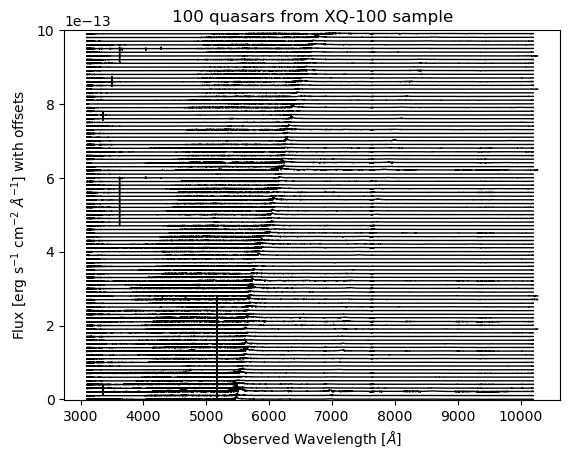

Text(0.5, 0, 'Redshift, z')

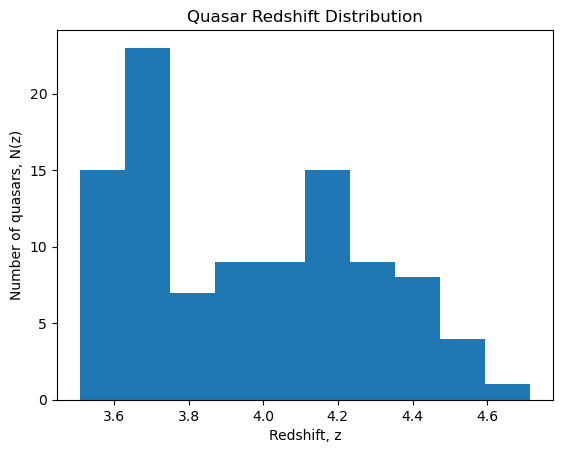

In [12]:
N_qso = 100 #len(qso_list)
flux_bias_plotting = 1e-14
for i in range(N_qso):
    df_i = df_tot[df_tot["qso_idx"] == i]
    wav_rest = df_i["wav"]
    flx = df_i["flx"]+flux_bias_plotting*i
    plt.plot(wav_rest, flx,lw=1,color='k')
plt.ylim(-1e-15,1e-14*N_qso)
plt.title("100 quasars from XQ-100 sample")
plt.ylabel(r"Flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$] with offsets")
plt.xlabel(r"Observed Wavelength [$\AA$]")
plt.show()

# N(z) distribution
plt.title("Quasar Redshift Distribution")
plt.hist(np.unique(df_tot["redshift"]))
plt.ylabel("Number of quasars, N(z)")
plt.xlabel("Redshift, z")

### Shifting into wavelength rest-frame

We shift into the rest-frame so that features like the Ly$\alpha$ line match up between each spectrum. Unfortunately, it looks like the fluxes of each spectrum are a lot different. We're going to have to find a way to normalize the spectra. By the way, we're only going to be attempting to reconstruct the red-side of the spectrum which is shaded in gray. The red-side (rightward of the 1216 Anstrom lyman alpha line) is easier because there are less absorptions and so the continuum is easier to predict.

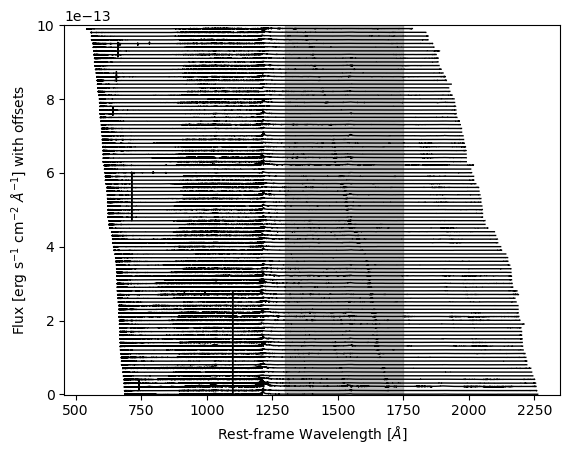

In [13]:
for i in range(100):
    df_i = df_tot[df_tot["qso_idx"] == i]
    wav_rest = df_i["wav_rest"]
    flx = df_i["flx"]
    plt.plot(wav_rest, flx+1e-14*i,lw=1,color='k')
plt.ylabel(r"Flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$] with offsets")
plt.xlabel(r"Rest-frame Wavelength [$\AA$]")
plt.ylim(-1e-15,1e-14+1e-14*i)
plt.axvspan(1300,1750,color='gray',alpha=0.5)
plt.show()

### Normalizing the spectra and then calculating average and variance of the quasar spectra

We'll use the sci-kit learn preprocessing module to do this

In [14]:
from sklearn import preprocessing
from scipy.interpolate import griddata

In [15]:
N_qso = 100
all_fluxes = [] 
num_wave_bins = []
mask_subset = (df_tot["wav_rest"]>1020)&(df_tot["wav_rest"]<1750)
df_subset = df_tot[mask_subset]
wave_grid = df_subset[df_subset["qso_idx"] == 0]["wav_rest"].values
for i in range(N_qso):
    df_i = df_subset[df_subset["qso_idx"] == i]
    regridded_flux = griddata(df_i["wav_rest"].values,df_i["cont"].values,wave_grid,method='linear')
    all_fluxes.append(regridded_flux[1:-1])
wave_grid = wave_grid[1:-1]
X = np.stack(all_fluxes) #(number of samples (100 quasars),number of features (flux in wavelength bins))

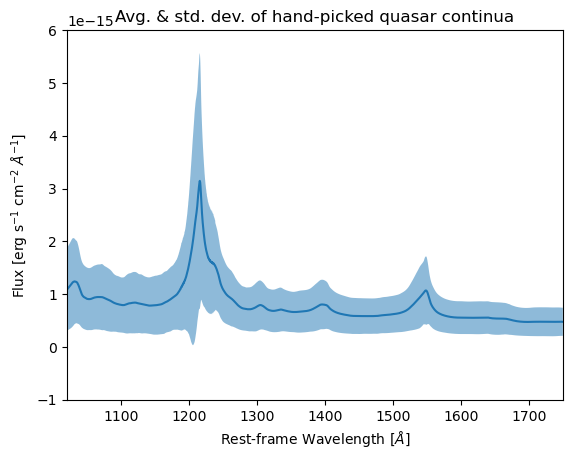

In [9]:
X_pp = preprocessing.normalize(X) #normed fluxes, num_quasars
mu = X.mean(0)
std = X.std(0)
plt.plot(wave_grid, mu)
plt.fill_between(wave_grid, mu - std, mu + std,alpha=0.5)
plt.xlim(1020,1750)
plt.ylim(-1e-15,6e-15)

plt.ylabel(r"Flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
plt.xlabel(r"Rest-frame Wavelength [$\AA$]")
plt.title("Avg. & std. dev. of hand-picked quasar continua");


### Getting feature vector for the red-side only

In [16]:
index_redside = np.where(wave_grid>1216)[0][0]
wave_grid_redside = wave_grid[wave_grid>1216]
X_red = X_pp[:,index_redside:]

In [17]:
from sklearn.decomposition import PCA
pca_full = PCA(n_components=10)
_ = pca_full.fit_transform(X_pp) 

pca_redside = PCA(n_components=10)
_ = pca_redside.fit_transform(X_red) 

Text(0.5, 0, 'Rest-frame Wavelength [$\\AA$]')

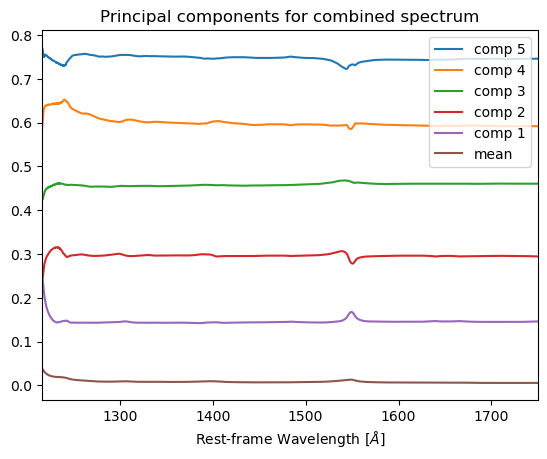

In [35]:
labels = ["comp 1", "comp 2", "comp 3","comp 4","comp 5"]
for i in [4,3,2,1,0]:
    offset = 0.15
    plt.plot(wave_grid,pca_full.components_[i]+offset*(i+1),label=labels[i])
plt.plot(wave_grid,pca_full.mean_,label='mean')
plt.legend()
plt.xlim(1216,1750)
plt.title("Principal components for combined spectrum")
plt.xlabel(r"Rest-frame Wavelength [$\AA$]")


In [18]:
import scipy.integrate as integrate
c_weights = np.zeros((100,10)) #full spectrum
d_weights = np.zeros((100,10)) #redside spectrum
for i in range(100):
    for j in range(10):
        ksi = pca_full.components_[j]
        integrand = (X_pp[i] - pca_full.mean_)*ksi
        c_weights[i][j] = integrate.trapezoid(integrand,x=wave_grid)
        
        zeta = pca_redside.components_[j]
        integrand = (X_red[i] - pca_redside.mean_)*zeta
        d_weights[i][j] = integrate.trapezoid(integrand,x=wave_grid_redside)

In [28]:
P = np.loadtxt("proj.dat") #10 by 10 projection matrix
zeta = np.loadtxt("zeta.dat") #redside spectrum
ksi = np.loadtxt("xi.dat") #whole spectrum
proj_calc = np.dot(np.linalg.pinv(d_weights),c_weights) #this is my version of P

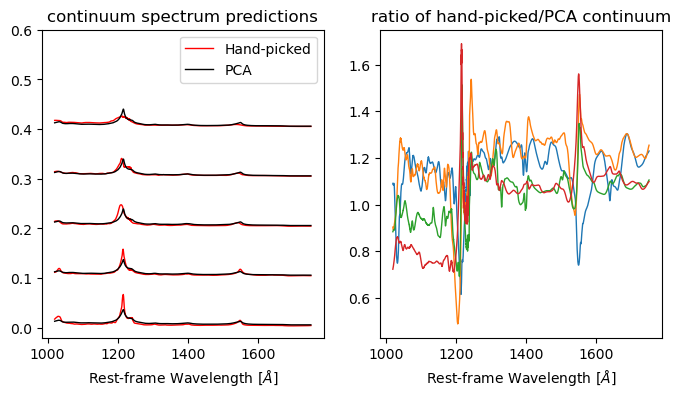

In [22]:
predicted_weights = np.dot(d_weights,P) # P and proj_calc are interchangeable

Y = pca_full.mean_ + np.dot(predicted_weights,pca_full.components_)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(8,4))
ax[0].plot(wave_grid,X_pp[0],color='red',label="Hand-picked",lw=1)
ax[0].plot(wave_grid,Y[0],color='k',label="PCA",lw=1)
offset = 0.1
for i in range(1,5):
    ax[0].plot(wave_grid,X_pp[i]+offset,color='red',lw=1)
    ax[0].plot(wave_grid,Y[i]+offset,color='k',lw=1)
    
    ax[1].plot(wave_grid,Y[i]/X_pp[i],lw=1)
    # ax[1].plot(wave_grid,Y[i]+offset,color='k',lw=1)
    offset+=0.1
ax[0].set_ylim(-0.02,offset+0.1)
ax[0].legend()
ax[0].set_title(r"continuum spectrum predictions")
ax[0].set_xlabel(r"Rest-frame Wavelength [$\AA$]")

ax[1].set_title(r"ratio of hand-picked/PCA continuum")
ax[1].set_xlabel(r"Rest-frame Wavelength [$\AA$]")

plt.savefig("reconstructed_spectra.png",dpi=200, bbox_inches='tight')